# Simulate binaural hearing when the stimulus is rotated around a ring of speakers.

In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


### First, some code to render a mouse's head and a ring of speakers

In [2]:

# MEASURE SOURCE ANGLE RELATIVE TO NOSE. POSITIVE IS CLOCKWISE WHEN LOOKING DOWN

def render_ring(num_speakers=16, radius=0.5, speaker_radius=0.025, ax=None):
    if not ax:
        fig, ax = plt.subplots(1,1)
        ax.set_xlim(-2*radius,2*radius)
        ax.set_ylim(-2*radius,2*radius)
        ax.set_aspect('equal')
    
    SpeakerAngles = np.linspace(0, np.pi*2, num=num_speakers, endpoint=False)
    for n in range(num_speakers):
        center = (np.sin(SpeakerAngles[n])*radius,
                  np.cos(SpeakerAngles[n])*radius  )
        ax.add_patch(mpatches.Circle(center,speaker_radius))

    return ax

def render_mouse(interaural_distance=0.0086, ax=None, 
                 ear_diameter=0.008, scale=3, xpos=0):
    if not ax:
        fig, ax = plt.subplots(1,1)
        ax.set_xlim(-2*radius,2*radius)
        ax.set_ylim(-2*radius,2*radius)
        ax.set_aspect('equal')

    x = interaural_distance/2*scale
    eye_y=1*interaural_distance*scale
    eye_r=interaural_distance/4*scale
    ear_height=1.25*ear_diameter*scale
    ear_width=1.25*ear_diameter/2*scale
    head_ytop=2.5*interaural_distance*scale
    head_ybot=0.75*interaural_distance*scale

    ax.add_patch(mpatches.Circle((x+xpos,eye_y),eye_r,color='black'))
    ax.add_patch(mpatches.Circle((-x+xpos,eye_y),eye_r,color='black'))
    ax.add_patch(mpatches.Polygon([[-x*1.5+xpos,-head_ybot],[0+xpos,head_ytop],[x*1.5+xpos,-head_ybot]],
            color='gray'))
    ax.add_patch(mpatches.Ellipse((x+xpos,0),ear_width,ear_height,30,color='slateblue'))
    ax.add_patch(mpatches.Ellipse((-x+xpos,0),ear_width,ear_height,-30,color='slateblue'))

    return ax

Text(0.5, 1.0, 'Interaural distance 8.6 mm\nHead centered at 0.4 m\n64 Speakers at 0.5 m')

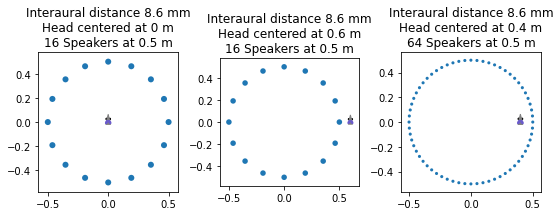

In [3]:
# Test it out
fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1,3, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0:,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

NumSpeakers = 16
Radius = 0.5
HeadPos = 0

ax1 = render_mouse(ax=ax1, xpos=HeadPos)
ax1 = render_ring(num_speakers=NumSpeakers, radius=Radius, ax=ax1)
ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_title('Interaural distance 8.6 mm\nHead centered at {} m\n'
            '{} Speakers at {} m'.format(HeadPos, NumSpeakers, Radius))

HeadPos = 0.6
ax2 = render_mouse(ax=ax2, xpos=HeadPos)
ax2 = render_ring(num_speakers=NumSpeakers, radius=Radius, ax=ax2)
ax2.autoscale()
ax2.set_aspect('equal')
ax2.set_title('Interaural distance 8.6 mm\nHead centered at {} m\n'
            '{} Speakers at {} m'.format(HeadPos, NumSpeakers, Radius))

NumSpeakers = 64
HeadPos = 0.4
ax3 = render_mouse(ax=ax3, xpos=HeadPos)
ax3 = render_ring(num_speakers=NumSpeakers, radius=Radius, ax=ax3, speaker_radius=0.025/2)
ax3.autoscale()
ax3.set_aspect('equal')
ax3.set_title('Interaural distance 8.6 mm\nHead centered at {} m\n'
            '{} Speakers at {} m'.format(HeadPos, NumSpeakers, Radius))

### Virtual sources

Virtual sources are sounds that come from a location between two speakers.
We will synthesize their sound using the two nearest speakers.
Next, let's find the nearest two speakers for an arbitrary virtual angle.
Subsequent code requires that the first speaker returned be the closest,
so be extra careful!

**Important note:** Our reference for virtual source angles is "north" 
(in front of the nose), going clockwise.

In [4]:
def virtual_source_angle(virtual_angle, num_speakers, radius):
    speaker_angles = np.linspace(0, 2*np.pi, num_speakers, endpoint=False)
    speaker_angles = np.expand_dims(speaker_angles,axis=0)
    virtual_angle = np.mod(virtual_angle, 2*np.pi)  # make angles between 0 and 2pi
    dist_mat = np.minimum(np.abs(virtual_angle - speaker_angles),
        np.abs(2*np.pi - (virtual_angle - speaker_angles)) )
    ClosestSourceAngle = np.take(speaker_angles, np.argmin(dist_mat, axis=1))
    if (virtual_angle.ndim > 0):
        ClosestSourceAngle = np.expand_dims(ClosestSourceAngle,1)

    dist_mat2 = dist_mat
    for rowidx, row in enumerate(dist_mat):
        dist_mat2[rowidx, row.argmin()] = np.inf
    NextClosestSourceAngle = np.take(speaker_angles, np.argmin(dist_mat2, axis=1))
    if (virtual_angle.ndim > 0):
        NextClosestSourceAngle = np.expand_dims(NextClosestSourceAngle,1)

    return  [ClosestSourceAngle, NextClosestSourceAngle]

### Synthetic speaker amplitudes for virtual sources

Next, we want to generate the amplitude that each of our two closest
speakers should be driven at. In free space, the sound that reaches the ear
will fall off in amplitude by 1/distance to the ear. We'll use the center
of the head as our target point and will match the synthesized amplitude
to what the virtual source would have created at that point. (We don't try
to match phase!). More complicatedly, speaking of phase, we need to be aware
of the fact that because the two speakers are different distances from the
ear, it's possible that their signal will combine destructively. So ideally,
we'd scale them to make sure that their sum has the right amplitude.

In order to do this, we will use 3 methods.
  - "Closest": This will just drive the closest speaker, with amplitude scaled
        by distance
  - "Naive": This will just scale the amplitude of the sound
        based on the relative angle between the virtual source and the
        two speakers.
  - "Phasor": This will take into account the relative phase of the signals.
  

In [5]:
def cos_triangle_rule(x1, x2, phi):
# Really useful formula for finding the length of a vector difference when you
# know the lengths of the two arguments and the angle between them.
# In other words, return ||A - B||, where phi is the angle between them,
# and ||A|| = x1 and ||B|| = x2.
    return np.sqrt(x1**2 + x2**2 - 2*x1*x2*np.cos(phi))

def virtual_source_amplitude(virtual_angle, radius, source1_angle, source2_angle, 
        freq, head_x=0, speed_of_sound=343.0, synthesis='phasor'):
#  We assume that the virtual source is on a ring with the given radius, and
#  that the head is positioned at the vertical center, and horizontally displaced
#  by head_x. The amplitude is equally split between the two given sources
#  based on their relative distance from the virtual source.
#  NOTE: source angles are measured clockwise from vertical axis, but head is displaced
#    in the horizontal axis
#  Finally, we assume the virtual amplitude is 1. Everything scales with that

    virtual_angle = np.mod(virtual_angle, 2*np.pi)  # make angles between 0 and 2pi
    source1_angle = np.mod(source1_angle, 2*np.pi)
    source2_angle = np.mod(source2_angle, 2*np.pi)

    virtual_distance = cos_triangle_rule(radius, head_x, np.pi/2 - virtual_angle)
    source1_distance = cos_triangle_rule(radius, head_x, np.pi/2 - source1_angle)
    source2_distance = cos_triangle_rule(radius, head_x, np.pi/2 - source2_angle)

    dAngle = np.minimum(np.abs(source2_angle-source1_angle), # Angle between sources. Note that this assumes
        np.abs(2*np.pi - (source2_angle-source1_angle)))     #  they are adjacent!

    angularDistance = np.minimum(np.abs(virtual_angle - source1_angle), # Take into account wrapping
            np.abs(2*np.pi - (virtual_angle - source1_angle)))

    source1_relative_angle = 1 - angularDistance/dAngle # Want amplitude to be large (close to 1)
    source2_relative_angle = 1 - source1_relative_angle #   for closest source, source1

    if synthesis=='phasor':
        omega = 2*np.pi*freq
        k = omega / speed_of_sound

        phi_v = -k*virtual_distance # This is the phase angle of the sound from virtual source.
        phi_1 = -k*source1_distance
        phi_2 = -k*source2_distance

        # If we wanted to match phase and amplitude of the virtual signal, it's easy
        #   Define a triangle by the three sounds in phase space. 
        #   Use the law of sines find out proper amplitudes.
        scale = (1/virtual_distance) / np.sin(phi_2 - phi_1)
        source1_amp = source1_distance * np.sin(phi_2 - phi_v) * scale
        source2_amp = source2_distance * np.sin(phi_v - phi_1) * scale
        
        # The downside of this is that at higher frequencies, we'll end up cycling
        #   our amplitudes really fast to match the phase. Instead, let's just
        #   smoothly interpolate our phase from one speaker to the next
        #  TBD.
                
        # Fix the situation where the speakers are at the same difference
        source1_amp = np.where(phi_2 != phi_1, source1_amp,
                source1_relative_angle)
        source2_amp = np.where(phi_2 != phi_1, source2_amp,
                source2_relative_angle)

    elif synthesis == 'naive':
        source1_amp = source1_relative_angle * source1_distance / virtual_distance
        source2_amp = source2_relative_angle * source2_distance / virtual_distance

    elif synthesis == 'closest':
        source1_amp = np.ones(source1_relative_angle.shape) * source1_distance / virtual_distance
        source2_amp = 0 * source1_amp # get dimensions right

    return [source1_amp, source2_amp]

### Calculate actual distances to ears

The speakers are being scaled to aim at the center of the head. 
The ears are off center of this. The cosine rule for triangles
helps us again here to find out the distance to each ear if
we know the distance and angle to a source and the interaural
distance

In [6]:
# remember - 0 degrees is straight ahead

def left_ear_distance(angle, radius, head_x=0, interaural_distance=0.0086):
    if (head_x - interaural_distance/2) < 0:
        return cos_triangle_rule(radius, head_x - interaural_distance/2, np.pi/2 + angle)
    else:
        return cos_triangle_rule(radius, head_x - interaural_distance/2, np.pi/2 - angle)

def right_ear_distance(angle, radius, head_x=0, interaural_distance=0.0086):
    if (head_x + interaural_distance/2) < 0:
        return cos_triangle_rule(radius, head_x + interaural_distance/2, np.pi/2 + angle)
    else:
        return cos_triangle_rule(radius, head_x + interaural_distance/2, np.pi/2 - angle)


### To simulate, we need the wave equation

This describes the signal which is detected at some distance from a spherically propagating
perfect sound source. The amplitude at unit distance (the units here are m, based on the
definition of the speed of sound) is <amp>. We do everything at time <t>=0, because
all the phases and so on scale by this.

In [7]:
def wave_eq(amp, r, freq, t=0,speed_of_sound = 343.0):
    omega = 2*np.pi*freq
    k = omega / speed_of_sound
    return (amp/r) * np.exp(1j * (omega*t - k*r))


### Make a helper function to run the simulation

In [8]:
def ring_audio_synthesis(num_speakers, radius, head_pos, frequencies, synthesis='phasor'):
    VirtualAngles = np.expand_dims(np.linspace(-np.pi, np.pi, 8*num_speakers, endpoint=False),axis=1)
    VirtualDistance = radius # This is a fixed assumption!!!
    VirtualAmp = 1 # This is a fixed assumption

    LR_Distances = [left_ear_distance(VirtualAngles, radius, head_pos),
                right_ear_distance(VirtualAngles, radius, head_pos)]

    DesiredSounds = [np.abs(wave_eq(VirtualAmp, LR_Distances[0], frequencies)),
                np.abs(wave_eq(VirtualAmp, LR_Distances[1], frequencies))]

    SynthAngle = virtual_source_angle(VirtualAngles, num_speakers, radius)
    SynthAmp = virtual_source_amplitude(VirtualAngles, radius, 
        SynthAngle[0], SynthAngle[1], frequencies, head_pos, synthesis=synthesis)

    LeftDistances = [left_ear_distance(s, radius, head_pos) for s in SynthAngle]    
    RightDistances = [right_ear_distance(s, radius, head_pos) for s in SynthAngle]    

    SynthesizedSounds = [
        np.abs(wave_eq(SynthAmp[0], LeftDistances[0], frequencies) + \
            wave_eq(SynthAmp[1], LeftDistances[1], frequencies)),
        np.abs(wave_eq(SynthAmp[0], RightDistances[0], frequencies) + \
            wave_eq(SynthAmp[1], RightDistances[1], frequencies))
    ]

    SynthesizedSoundAtCenter = np.abs(wave_eq(SynthAmp[0], LR_Distances[0], frequencies) + \
            wave_eq(SynthAmp[1], LR_Distances[1], frequencies))

    return VirtualAngles, LR_Distances, DesiredSounds, SynthAngle, SynthAmp, \
           [LeftDistances, RightDistances], SynthesizedSounds, SynthesizedSoundAtCenter

### And another one to plot results

In [9]:
def plot_results(virtual_angles, frequencies, radius, head_x, num_speakers, 
            desired_sounds, synthesized_sounds,
            synthesis='phasor',
            speaker_radius=0.05/2, # 5 cm diameter speakers
            mouse_scale=3,
            interaural_distance=0.0086): # 8.6 mm

    fig = plt.figure(figsize=(20,12))
    gs = fig.add_gridspec(2,5, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0:,0])
    ax2 = fig.add_subplot(gs[0,1:3])
    ax3 = fig.add_subplot(gs[1,1:3])
    ax4 = fig.add_subplot(gs[0,3:])
    ax5 = fig.add_subplot(gs[1,3:])

    ax1 = render_mouse(interaural_distance=interaural_distance, ax=ax1, 
            scale=mouse_scale, xpos=head_x)
    ax1 = render_ring(num_speakers=num_speakers, radius=radius, ax=ax1, speaker_radius=speaker_radius)
    ax1.autoscale()
    ax1.set_aspect('equal')
    ax1.set_title('Interaural distance 8.6 mm\nHead centered at {} m\n'
                '{} Speakers at {} m'.format(head_x, num_speakers, radius))

    vmax = 1.25 * np.max(desired_sounds[1])
    vmin = np.min(desired_sounds[1])
    if (vmin < 0):
        vmin = 1.25 * vmin
    else:
        vmin = 0.5 * vmin

    RightEarSignal = ax2.imshow((synthesized_sounds[1]).T, 
        origin='lower', interpolation=None, aspect='auto', 
        vmin=vmin, vmax=vmax,
        extent=[virtual_angles[0,0],virtual_angles[-1,0],
                frequencies[0,0],frequencies[0,-1]])
    ax2.set_yscale('log')
    ax2.set_ylabel('Virtual Source Frequency')
    RightEarSignal.cmap.set_over('red')
    RightEarSignal.cmap.set_over('pink')

    fig.colorbar(RightEarSignal, ax=ax2, extend='max')
    ax2.set_title('Phasor Synthesis Sound at Right Ear')

    DesiredRightEar = ax3.imshow(desired_sounds[1].T, 
            origin='lower', interpolation=None, aspect='auto',
            vmin=vmin, vmax=vmax, 
            extent=[virtual_angles[0,0],virtual_angles[-1,0],
                    frequencies[0,0],frequencies[0,-1]])
    ax3.set_xlabel('Virtual Source Angle')
    ax3.set_yscale('log')
    ax3.set_ylabel('Virtual Source Frequency')
    fig.colorbar(DesiredRightEar, ax=ax3, extend='both')
    ax3.set_title('Desired Sound at Right Ear')

    # Next, plot ILDs
    if head_x > radius:
        first = 0
        second = 1
        label = '(Left - Right)'
    else:
        first = 1
        second = 0
        label = '(Right - Left)'

    vmax = 1.25 * np.max(desired_sounds[first] - desired_sounds[second])
    vmin = 1.25 * np.min(desired_sounds[first] - desired_sounds[second])

    ILD = ax4.imshow((synthesized_sounds[first] - synthesized_sounds[second]).T, 
            origin='lower', interpolation=None, aspect='auto', 
            vmin=vmin, vmax=vmax, 
            extent=[virtual_angles[0,0],virtual_angles[-1,0],
                    frequencies[0,0],frequencies[0,-1]])

    ax4.set_yscale('log')
    ax4.set_ylabel('Virtual Source Frequency')
    ILD.cmap.set_over('red')
    ILD.cmap.set_under('pink')
    fig.colorbar(ILD, ax=ax4, extend='both')
    ax4.set_title('Phasor Synthesis Interaural Level Difference {}'.format(label))

    ExpectedILD = ax5.imshow(desired_sounds[first].T - desired_sounds[second].T, 
            origin='lower', interpolation=None, aspect='auto',
            vmin=vmin, vmax=vmax, 
            extent=[virtual_angles[0,0],virtual_angles[-1,0],
                    frequencies[0,0],frequencies[0,-1]])
    ax5.set_yscale('log')
    ax5.set_xlabel('Virtual Source Angle')
    ax5.set_ylabel('Virtual Source Frequency')
    fig.colorbar(ExpectedILD, ax=ax5, extend='both')
    ax5.set_title('Expected Interaural Level Difference {}'.format(label))

    return (fig, ax1, ax2, ax3, ax4, ax5)

### Let's do it!

Simulate the situation where the mouse is offset from the center of the ring, but still inside.

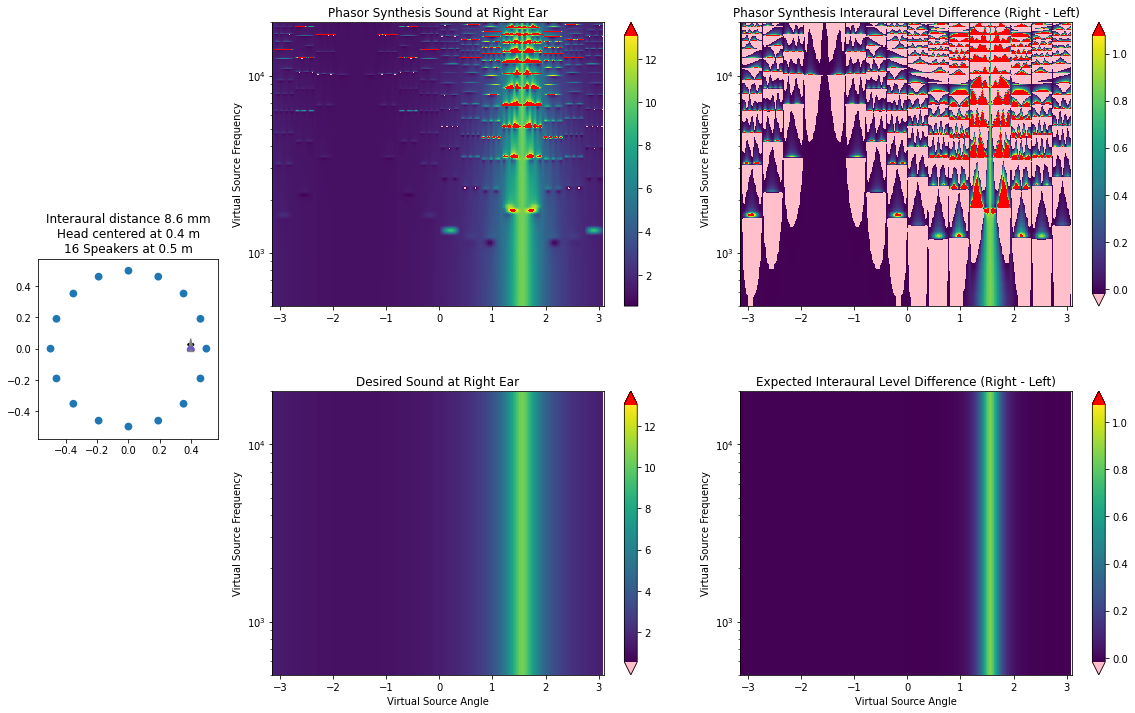

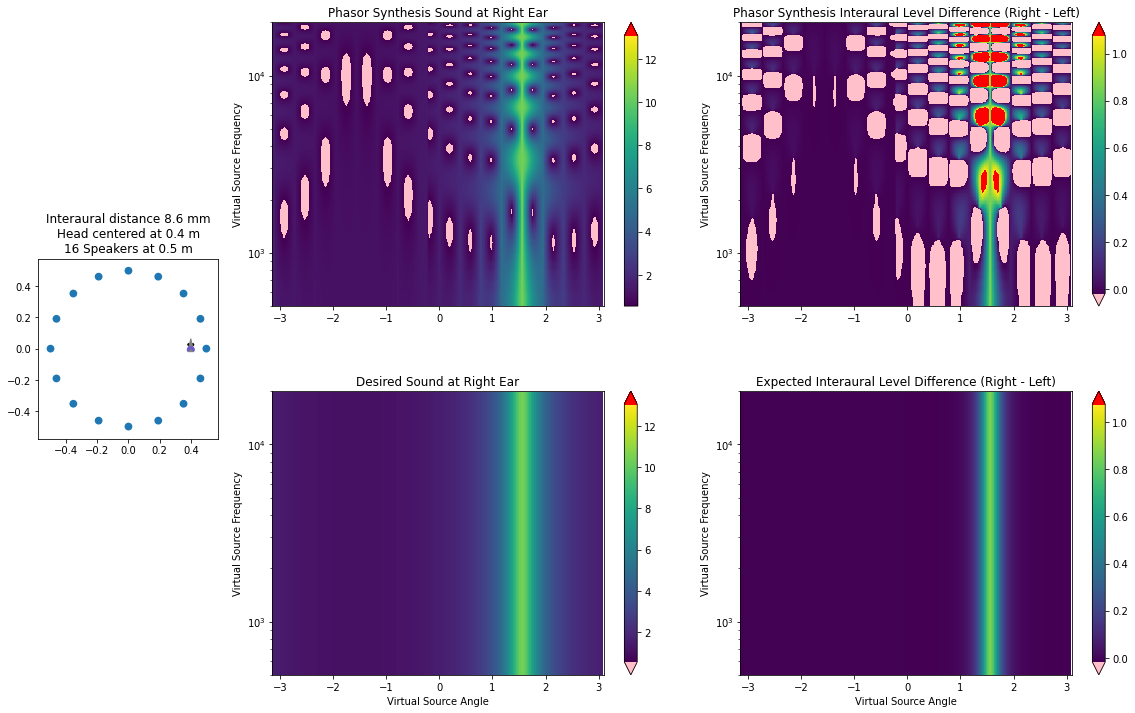

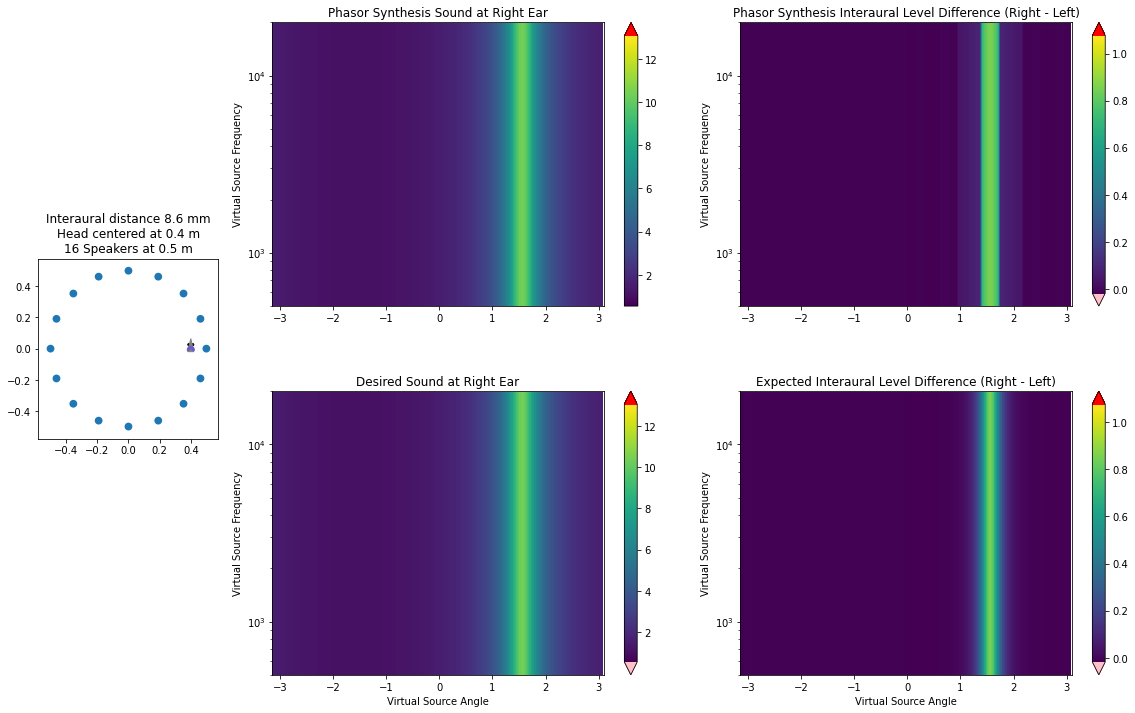

In [10]:
#%%
# Info about ring
NumSpeakers = 16
Radius = 0.5 # 50 cm radius

# Mouse position
HeadPos = 0.4


Frequencies = np.expand_dims(np.linspace(500,20000,num=200),axis=0)

VirtualAngles, LR_Distances, DesiredSounds, SynthAngle, SynthAmp, LR2, SynthesizedSounds, SynthesizedSoundsAtCenter = \
    ring_audio_synthesis(NumSpeakers, Radius, HeadPos, Frequencies)

#%%


#%%
plot_results(VirtualAngles, Frequencies, Radius, HeadPos, NumSpeakers, 
        DesiredSounds, SynthesizedSounds);

#%%
VirtualAngles, LR_Distances, DesiredSounds, SynthAngle, SynthAmp, LR2, SynthesizedSounds, SynthesizedSoundsAtCenter = \
    ring_audio_synthesis(NumSpeakers, Radius, HeadPos, Frequencies, synthesis='naive')

plot_results(VirtualAngles, Frequencies, Radius, HeadPos, NumSpeakers, 
        DesiredSounds, SynthesizedSounds);
#%%
VirtualAngles, LR_Distances, DesiredSounds, SynthAngle, SynthAmp, LR2, SynthesizedSounds, SynthesizedSoundsAtCenter = \
    ring_audio_synthesis(NumSpeakers, Radius, HeadPos, Frequencies, synthesis='closest')

plot_results(VirtualAngles, Frequencies, Radius, HeadPos, NumSpeakers, 
        DesiredSounds, SynthesizedSounds);

# %%